In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [192]:
df = pd.read_csv("../data/dfgeopoli.csv")

In [193]:
df.columns

Index(['year', 'country_id_o', 'country_o', 'country_id_d', 'country_d',
       'contig', 'distcap', 'dist', 'comlang_off', 'comlang_ethno', 'comrelig',
       'pop_o', 'pop_d', 'gdp_o', 'gdp_d', 'gdpcap_o', 'gdpcap_d', 'fta_wto',
       'tradeflow_comtrade_o', 'tradeflow_comtrade_d', 'tradeflow_imf_o',
       'tradeflow_imf_d', 'IdealPointDistance', 'arms', 'tot_o', 'tot_d',
       'tgdp_ratio_o', 'tgdp_ratio_d', 'avgtradeflow', 'logtradeflow',
       'v2x_polyarchy_o', 'v2x_libdem_o', 'v2x_partipdem_o', 'v2x_delibdem_o',
       'v2x_egaldem_o', 'v2x_polyarchy_d', 'v2x_libdem_d', 'v2x_partipdem_d',
       'v2x_delibdem_d', 'v2x_egaldem_d', 'allexports', 'chemicalexports',
       'consumerexports', 'foodexports', 'machineryexports',
       'manufacturesexports', 'logallexports', 'logchemicalexports',
       'logconsumerexports', 'logfoodexports', 'logmachineryexports',
       'logmanufacturesexports', 'v2x_polyarchy_diff', 'v2x_libdem_diff',
       'v2x_partipdem_diff', 'v2x_delibdem_d

In [194]:
X = df[['geopolitical_closeness_index_fa', 'distcap', 'gdpcap_d', 'pop_d']]
vif_df = pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df) # no multicollinearity present

                           Feature       VIF
0  geopolitical_closeness_index_fa  1.351128
1                          distcap  1.369162
2                         gdpcap_d  1.715260
3                            pop_d  1.046732


In [195]:
df[['geopolitical_closeness_index_fa', 'distcap', 'gdpcap_d', 'pop_d']].corrwith(df['logallexports'])

# makes sense, expect the signs of each variable

geopolitical_closeness_index_fa    0.369670
distcap                           -0.289222
gdpcap_d                           0.410146
pop_d                              0.365941
dtype: float64

In [199]:
df_2 = df.dropna(subset=['logallexports'])
df_2 = df_2.sort_values(by='year')

In [201]:
# TimeSeriesSplit Cross-validation function
def timeseries_cv(model, X, y, folds = 6):
    tscv = TimeSeriesSplit(n_splits=folds) # around 5 years per fold, there are 32 years in total
    mse_list = []
    r2_list = []
    mae_list = []
    mape_list = []
    
    predictions = pd.Series(index=Y.index, dtype=float)

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        if hasattr(X, 'iloc'): # this is because some models uses the np, some uses pandas
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
        if hasattr(y, 'iloc'): # this is because some models uses the np, some uses pandas
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            y_train, y_test = y[train_index], y[test_index] 
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mse_list.append(mse)
        r2_list.append(r2)
        mae_list.append(mae)
        mape_list.append(mape)
        
        predictions.loc[y_test.index] = pd.Series(y_pred.flatten(), index=y_test.index)

    metrics = {
        'avg_mse': np.mean(mse_list), 
        'avg_r2': np.mean(r2_list), 
        'avg_mae': np.mean(mae_list), 
        'avg_mape': np.mean(mape_list),
        'folds': folds
    }

    return predictions, metrics

In [202]:
# Linear Regression
linearX = df_2[['geopolitical_closeness_index_fa', 'distcap', 'gdpcap_d', 'pop_d']]
linearY = df_2[['logallexports']]

scaler = StandardScaler()
linearX = scaler.fit_transform(linearX)

linearModel = LinearRegression()

linearPredictions, linearMetrics = timeseries_cv(linearModel, linearX, linearY)
print(linearMetrics)

{'avg_mse': 5.351954783991917, 'avg_r2': 0.3402497806490656, 'avg_mae': 1.7507180953110562, 'avg_mape': 0.1027864980866683, 'folds': 6}


In [203]:
# XGBoost
xgboostX = df_2[['pop_d', 'gdpcap_d', 'distcap', 'geopolitical_closeness_index_fa']].copy()
xgboostX['log_pop_d'] = np.log1p(xgboostX['pop_d'])
xgboostX['log_gdpcap_d'] = np.log1p(xgboostX['gdpcap_d'])

scaler = StandardScaler()
xgboostX[['log_pop_d', 'log_gdpcap_d', 'distcap']] = scaler.fit_transform(xgboostX[['log_pop_d', 'log_gdpcap_d', 'distcap']])
xgboostX = xgboostX[['distcap', 'geopolitical_closeness_index_fa', 'log_pop_d', 'log_gdpcap_d']]
xgboostY = df_2[['logallexports']]

# need to relook at the settings
xgboostModel = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=222
)

xgboostPredictions, xgboostMetrics = timeseries_cv(xgboostModel, xgboostX, xgboostY)
print(xgboostMetrics)

{'avg_mse': 1.945028140764992, 'avg_r2': 0.7611592549313806, 'avg_mae': 0.9960505691933818, 'avg_mape': 0.060803595055456024, 'folds': 6}


In [204]:
# Random forest regression
rfX = df_2[['pop_d', 'gdpcap_d', 'distcap', 'geopolitical_closeness_index_fa']].copy()
rfX['log_pop_d'] = np.log1p(rfX['pop_d'])
rfX['log_gdpcap_d'] = np.log1p(rfX['gdpcap_d'])
rfX = rfX[['distcap', 'geopolitical_closeness_index_fa', 'log_pop_d', 'log_gdpcap_d']]
rfY = df_2['logallexports']

# relook at settings
rfModel = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=222)

rfPredictions, rfMetrics = timeseries_cv(rfModel, rfX, rfY)
print(rfMetrics)

{'avg_mse': 1.5264539899671696, 'avg_r2': 0.8106707404357317, 'avg_mae': 0.8216719737253507, 'avg_mape': 0.05068634428337373, 'folds': 6}


In [205]:
# Light GBM
lgbmX = df_2[['pop_d', 'gdpcap_d', 'distcap', 'geopolitical_closeness_index_fa']].copy()
lgbmX['log_pop_d'] = np.log1p(lgbmX['pop_d'])
lgbmX['log_gdpcap_d'] = np.log1p(lgbmX['gdpcap_d'])
lgbmX = lgbmX[['distcap', 'geopolitical_closeness_index_fa', 'log_pop_d', 'log_gdpcap_d']]
lgbmY = df_2[['logallexports']]

lgbmModel = LGBMRegressor(n_estimators=100, max_depth=10, random_state=222, verbosity = -1) # verbosity mutes output
lgbmPredictions, lgbmMetrics =  timeseries_cv(lgbmModel, lgbmX, lgbmY)
print(lgbmMetrics)

{'avg_mse': 1.33093316541614, 'avg_r2': 0.8342353644462733, 'avg_mae': 0.7938654239560674, 'avg_mape': 0.048379292164882216, 'folds': 6}


In [206]:
df_2['linearPrediction'] = linearPredictions
df_2['xgboostPrediction'] = xgboostPredictions
df_2['rfPrediction'] = rfPredictions
df_2['lgbmPrediction'] = lgbmPredictions

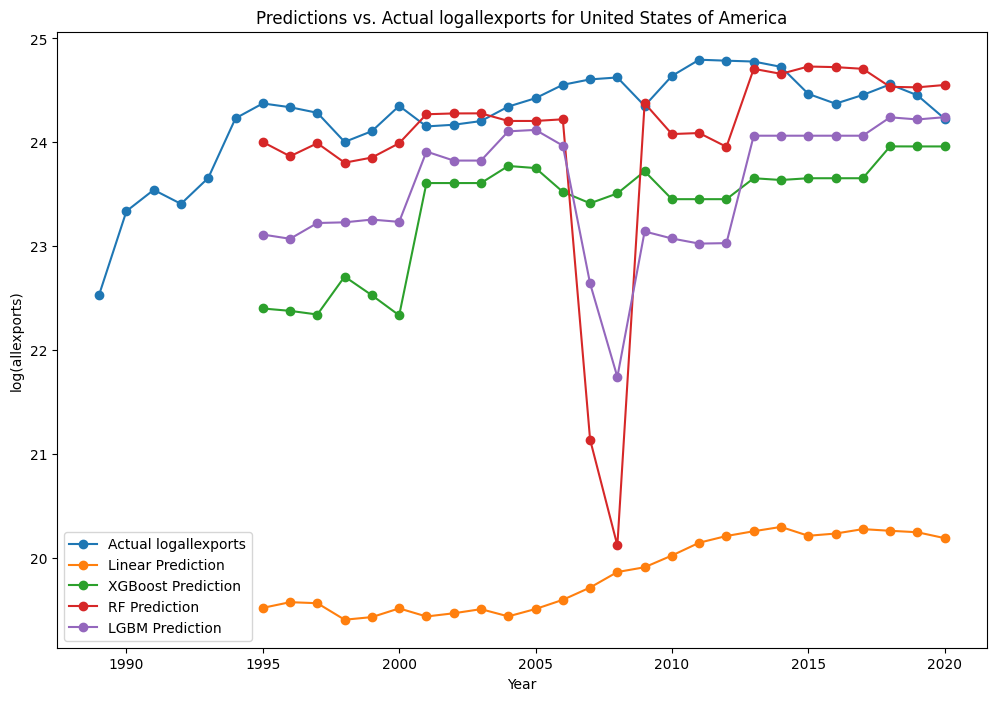

In [207]:
df_filtered = df_2[df_2['country_d'] == 'Malaysia']

plt.figure(figsize=(12, 8))
plt.plot(df_filtered['year'], df_filtered['logallexports'], label='Actual logallexports', marker='o')
plt.plot(df_filtered['year'], df_filtered['linearPrediction'], label='Linear Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['xgboostPrediction'], label='XGBoost Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['rfPrediction'], label='RF Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['lgbmPrediction'], label='LGBM Prediction', marker='o')

# Label the plot
plt.xlabel('Year')
plt.ylabel('log(allexports)')
plt.title('Predictions vs. Actual logallexports for United States of America')
plt.legend()
plt.show()